In [1]:
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt

from sklearn.preprocessing import OneHotEncoder, LabelEncoder, MinMaxScaler
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, GridSearchCV

import xgboost as xgb

# Bank Marketing Data Set

Our goal is to predict if client will subscribe a term deposit. Let's begin with data reading and displaing for better understandning.

In [2]:
data = pd.read_csv('mimuwml2021/bank-classification.csv')
data

,id,birth_date,job,marital,education,default,housing,loan,contact_date,contact,campaign,pdays,previous,poutcome,y
0,1,1952-03-23,housemaid,married,basic.4y,no,no,no,2008-05-12,telephone,1,999,0,nonexistent,no
1,2,1951-03-24,services,married,high.school,unknown,no,no,2008-05-26,telephone,1,999,0,nonexistent,unknown
2,3,1971-05-19,services,married,high.school,no,yes,no,2008-05-05,telephone,1,999,0,nonexistent,no
3,4,1968-01-24,admin.,married,basic.6y,no,no,no,2008-05-19,telephone,1,999,0,nonexistent,unknown
4,5,1952-05-11,services,married,high.school,no,no,yes,2008-05-19,telephone,1,999,0,nonexistent,unknown
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41183,41184,1938-03-19,retired,married,professional.course,no,yes,no,2010-11-19,cellular,1,999,0,nonexistent,unknown
41184,41185,1964-10-10,blue-collar,married,professional.course,no,no,no,2010-11-12,cellular,1,999,0,nonexistent,unknown
41185,41186,1954-10-06,retired,married,university.degree,no,yes,no,2010-11-12,cellular,2,999,0,nonexistent,no
41186,41187,1967-03-15,technician,married,professional.course,no,no,no,2010-11-26,cellular,1,999,0,nonexistent,unknown


# Data visualisation
Let's plot dependencies between different categories and will to subscribe a term deposit.

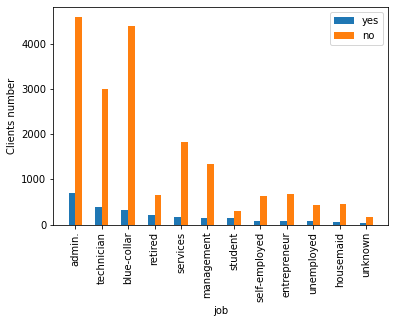

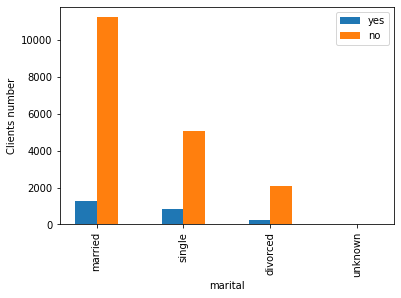

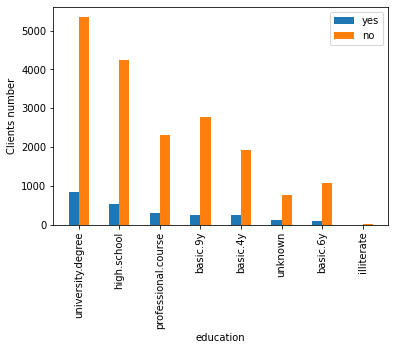

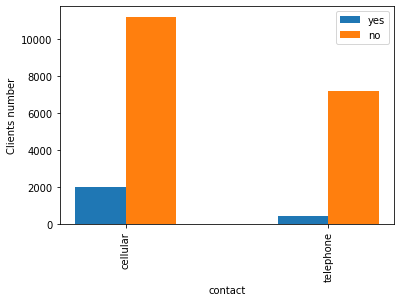

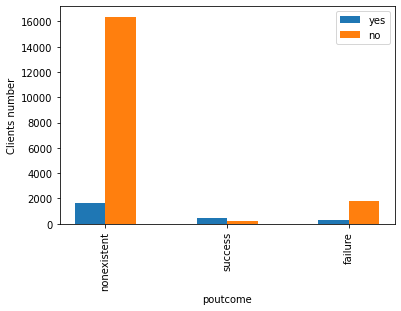

In [3]:
def visualisation(data, columns):
    for column in columns:
        data_plt = pd.DataFrame()
        data_plt['yes'] = data[data['y'] == 'yes'][column].value_counts()
        data_plt['no'] = data[data['y'] == 'no'][column].value_counts()
        data_plt.plot(kind='bar')
        plt.xlabel(column)
        plt.ylabel('Clients number')
        plt.autoscale()
        plt.show()

visualisation(data, ['job', 'marital', 'education', 'contact', 'poutcome'])


# Data transformation
Firstable, prepare encoders for certain columns in data set. We use OneHotEncoder for columns with different subcategories and LabelEncoder for columns where yes or no is an option. Lists of columns contain encoders itself under index 0. All lists are gathered in EncoderList to easier manage encoding.

In [4]:
OneHotEncoderList = [
    OneHotEncoder(sparse=False),
    'job',
    'marital',
    'education',
    'contact',
    'poutcome'
]

LabelEncoderList = [
    LabelEncoder(),
    'default',
    'housing',
    'loan'
]

EncoderList = [
    OneHotEncoderList,
    LabelEncoderList
]

## Function used to apply encoders
Function used to apply earlier prepared encoders. If LabelEncoder is applied, it changes values in certain column to 0 for no and 1 for yes. If OneHotEncoder is applied it appends new columns at the end of data frame and removes processed column. It is applied after removing unknown values. Returns processed data frame.

In [5]:
def applyEncoders(data):
    for columns in EncoderList:
        encoder = columns[0]
        for column in columns[1:]:
            if column in data.columns:
                print(f'column: {column}')
                data_col = np.array(encoder.fit_transform(data[[column]]), dtype=np.int)
                if hasattr(encoder, 'classes_'):
                    print(encoder.classes_)
                    data[column] = data_col.astype(str)
                elif hasattr(encoder, 'categories_'):
                    columns_names = encoder.categories_[0]
                    print(columns_names)
                    data_col = pd.DataFrame(data_col.astype(str), columns=columns_names)
                    data = data.join(data_col, rsuffix=column)
                    data.drop(column, axis=1, inplace=True)
                
            else:
                print(f'No column: {column}')
    return data

## Replace unknown values
Fill cells that contain 'unknown' values with randomly chosen values from possible ones with appriopriate, precalculated probability.

In [6]:
def fillUnknownCells(data):
    for column in ['job', 'marital', 'education', 'default', 'housing', 'loan']:
        data[column].replace(to_replace="unknown", value=np.nan, inplace=True)
        occurence = data[column].value_counts(normalize=True)
        data[column].fillna(np.random.choice(occurence.index, p=occurence.values), inplace=True)


## Prepare dates
After analysing contact dates we can see that last calls were made on 30th November 2010. According to that age and days from the last contact with each person is calculated respectively this date year plus one and day plus one to avoid zeros.

In [7]:
def changeDates(data):
    max_contact_date = pd.to_datetime(max(data['contact_date']))
    print(f'Last contact: {max_contact_date}')
    data['days_after_contact'] = (max_contact_date + pd.Timedelta(days=1) - pd.DatetimeIndex(data['contact_date'])).days
    data.drop('contact_date', axis=1, inplace=True)
    data['age'] = max_contact_date.year + 1 - pd.DatetimeIndex(data['birth_date']).year
    data.drop('birth_date', axis=1, inplace=True)
    

## Data normalization
All numeric columns are normalized with MinMaxScaler except age which is normalized with log function to better refflect age groups.

In [8]:
def normalizeData(data):
    for column in ['days_after_contact', 'pdays', 'previous']:
        scaler = MinMaxScaler()
        data[column] = scaler.fit_transform(data[[column]])
    for column in ['age']:
        data[column] = np.log(data[column])


## Extracting training and prediction sets
Function used to extract data according to values in 'y' column.

In [9]:
def getTrainAndPredictionSet(data):
    train_set = data.loc[data['y'] != 'unknown']
    prediction_set = data.loc[data['y'] == 'unknown']
    prediction_set.drop('y', axis=1, inplace=True)
    return train_set, prediction_set

## Data transformation
Applying all prepared functions to transform data for training

In [10]:
def transformData(data):
    fillUnknownCells(data)
    changeDates(data)
    data['pdays'] = data['pdays'].replace(999, 0)
    normalizeData(data)
    data = applyEncoders(data)
    train_set, prediction_set = getTrainAndPredictionSet(data)
    encoder = LabelEncoder()
    train_set['y'] = encoder.fit_transform(train_set[['y']])
    
    return train_set, prediction_set

In [11]:
train_set, prediction_set = transformData(data)

Last contact: 2010-11-30 00:00:00
column: job
['admin.' 'blue-collar' 'entrepreneur' 'housemaid' 'management' 'retired'
 'self-employed' 'services' 'student' 'technician' 'unemployed']
column: marital
['divorced' 'married' 'single']
column: education
['basic.4y' 'basic.6y' 'basic.9y' 'high.school' 'illiterate'
 'professional.course' 'university.degree']
column: contact
['cellular' 'telephone']
column: poutcome
['failure' 'nonexistent' 'success']
column: default
['no' 'yes']
column: housing
['no' 'yes']
column: loan
['no' 'yes']


In [12]:
train_set

,id,default,housing,loan,campaign,pdays,previous,y,days_after_contact,age,...,basic.9y,high.school,illiterate,professional.course,university.degree,cellular,telephone,failure,nonexistent,success
0,1,0,0,0,1,0.000000,0.000000,0,0.988335,4.077537,...,0,0,0,0,0,0,1,0,1,0
2,3,0,1,0,1,0.000000,0.000000,0,0.995758,3.688879,...,0,1,0,0,0,0,1,0,1,0
5,6,0,0,0,1,0.000000,0.000000,0,0.995758,3.871201,...,1,0,0,0,0,0,1,0,1,0
7,8,0,0,0,1,0.000000,0.000000,0,0.980912,3.784190,...,0,0,0,0,1,0,1,0,1,0
8,9,0,1,0,1,0.000000,0.000000,0,0.995758,3.295837,...,0,0,0,1,0,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41178,41179,0,0,0,2,0.222222,0.428571,1,0.027572,4.127134,...,0,0,0,0,1,1,0,0,0,1
41181,41182,0,1,0,1,0.000000,0.000000,1,0.026511,3.637586,...,0,0,0,0,1,1,0,0,1,0
41182,41183,0,1,0,1,0.333333,0.142857,0,0.026511,3.401197,...,0,0,0,0,0,1,0,0,0,1
41185,41186,0,1,0,2,0.000000,0.000000,0,0.019088,4.043051,...,0,0,0,0,1,1,0,0,1,0


In [13]:
prediction_set

,id,default,housing,loan,campaign,pdays,previous,days_after_contact,age,admin.,...,basic.9y,high.school,illiterate,professional.course,university.degree,cellular,telephone,failure,nonexistent,success
1,2,0,0,0,1,0.0,0.0,0.973489,4.094345,0,...,0,1,0,0,0,0,1,0,1,0
3,4,0,0,0,1,0.0,0.0,0.980912,3.761200,1,...,0,0,0,0,0,0,1,0,1,0
4,5,0,0,1,1,0.0,0.0,0.980912,4.077537,0,...,0,1,0,0,0,0,1,0,1,0
6,7,0,0,0,1,0.0,0.0,0.980912,4.127134,1,...,0,0,0,1,0,0,1,0,1,0
9,10,0,1,0,1,0.0,0.0,0.988335,3.332205,0,...,0,1,0,0,0,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41179,41180,0,1,0,3,0.0,0.0,0.011665,4.158883,0,...,0,0,0,1,0,1,0,0,1,0
41180,41181,0,0,0,2,0.0,0.0,0.026511,3.610918,1,...,0,0,0,0,1,1,0,0,1,0
41183,41184,0,1,0,1,0.0,0.0,0.011665,4.290459,0,...,0,0,0,1,0,1,0,0,1,0
41184,41185,0,0,0,1,0.0,0.0,0.019088,3.850148,0,...,0,0,0,1,0,1,0,0,1,0


## Split data into training set and test set
Split training set to verify model accuracy.

In [14]:
def split_data(data, frac=0.9):
    length = len(data)
    train_set = data.sample(n=int(length * frac), random_state=12)
    rest_set = data[~data.index.isin(train_set.index)]
    rest_set = rest_set.sample(frac=1)
    return train_set, rest_set


## Prepare and split data
Remove id column which should not be used in training.

In [15]:
train_set.drop('id', axis=1, inplace=True)
train_set, test_set = split_data(train_set)
train_set.reset_index(drop=True, inplace=True)
test_set.reset_index(drop=True, inplace=True)
print(f'train_set: {train_set.shape} test_set: {test_set.shape}')

train_set: (18719, 35) test_set: (2080, 35)


## Split X and Y values

In [16]:
def splitXY(data):
    Y = data['y']
    return data.drop('y', axis=1), Y
    

In [17]:
trainX, trainY = splitXY(train_set)
testX, testY = splitXY(test_set)

# Prepare model
Create model which uses cross validation during training and RandomForest as estimator. Cross validation is performed with random records. Grid parameters are chosen to maximize roc_auc function without great influence on time efficiency.

In [18]:
random_state = 12
n_jobs = -1

def getModel():
    cv = StratifiedKFold(shuffle=True, n_splits=5, random_state=random_state)
    grid_params_rf = [{
                'rf__criterion': ['entropy'],
                'rf__min_samples_leaf': [80, 100, 120],
                'rf__max_depth': [23, 25, 27],
                'rf__min_samples_split': [3, 5],
                'rf__n_estimators' : [60, 70, 80]
                }]
    pipe_rf = Pipeline([('rf', RandomForestClassifier(random_state=random_state, oob_score=True, n_jobs=n_jobs))])

    return GridSearchCV(estimator=pipe_rf, param_grid=grid_params_rf,
                     scoring='roc_auc', cv=cv)

# Let's train
Using prepared model to perform training on extracted training set. AUC score and accuracy is calculated on test set extracted earlier from data set. Best parameters chosen by model are printed just for information.

In [19]:

model = getModel()
start = time.time()
print('RandomForest as estimator, training...')
print()
print(f'Train set shape: {trainX.shape}')
print()
model.fit(trainX, trainY)
auc = model.score(testX, testY)
acc = accuracy_score(testY, model.predict(testX))
print(f'roc_auc: {auc} accuracy rate: {acc}')
print()
print(f'Best parameters: {model.best_params_}')
print()
print(f'Total time: {time.time() - start}')

RandomForest as estimator, training...

Train set shape: (18719, 34)

roc_auc: 0.8252302420218462 accuracy rate: 0.8961538461538462

Best parameters: {'rf__criterion': 'entropy', 'rf__max_depth': 23, 'rf__min_samples_leaf': 100, 'rf__min_samples_split': 3, 'rf__n_estimators': 60}

Total time: 166.1023449897766


# Producing predictions for submition

In [20]:
prediction_set

,id,default,housing,loan,campaign,pdays,previous,days_after_contact,age,admin.,...,basic.9y,high.school,illiterate,professional.course,university.degree,cellular,telephone,failure,nonexistent,success
1,2,0,0,0,1,0.0,0.0,0.973489,4.094345,0,...,0,1,0,0,0,0,1,0,1,0
3,4,0,0,0,1,0.0,0.0,0.980912,3.761200,1,...,0,0,0,0,0,0,1,0,1,0
4,5,0,0,1,1,0.0,0.0,0.980912,4.077537,0,...,0,1,0,0,0,0,1,0,1,0
6,7,0,0,0,1,0.0,0.0,0.980912,4.127134,1,...,0,0,0,1,0,0,1,0,1,0
9,10,0,1,0,1,0.0,0.0,0.988335,3.332205,0,...,0,1,0,0,0,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41179,41180,0,1,0,3,0.0,0.0,0.011665,4.158883,0,...,0,0,0,1,0,1,0,0,1,0
41180,41181,0,0,0,2,0.0,0.0,0.026511,3.610918,1,...,0,0,0,0,1,1,0,0,1,0
41183,41184,0,1,0,1,0.0,0.0,0.011665,4.290459,0,...,0,0,0,1,0,1,0,0,1,0
41184,41185,0,0,0,1,0.0,0.0,0.019088,3.850148,0,...,0,0,0,1,0,1,0,0,1,0


In [21]:
prediction_set.reset_index(drop=True, inplace=True)
pred_id = pd.DataFrame(prediction_set['id'])
prediction_set.drop('id', axis=1, inplace=True)
print(f'train_set: {prediction_set.shape}')



train_set: (20389, 34)


In [22]:
predictions = pd.DataFrame(model.predict_proba(prediction_set)[:,1])
print(f'Predictions shape: {predictions.shape}')

Predictions shape: (20389, 1)


In [23]:
preds_to_csv = pred_id.join(predictions)
preds_to_csv.rename(columns={0: 'y', 'id': 'Id'}, inplace=True)
preds_to_csv

,Id,y
0,2,0.030023
1,4,0.035742
2,5,0.032547
3,7,0.037633
4,10,0.065199
...,...,...
20384,41180,0.356123
20385,41181,0.357694
20386,41184,0.393776
20387,41185,0.338262


In [24]:
preds_to_csv.to_csv('kaggle.csv', index=False)